# PAMAP2 - Xception-Transformer


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchsummary import summary
from sklearn.manifold import TSNE
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        ys.append(stats.mode(labels, keepdims=True)[0][0])
        Xs.append(x)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

def prepare_data_split(df, time_steps, steps, activity_mapping):
    X = df.drop(columns=['activityID', 'subject'])
    y = df['activityID'].map(activity_mapping)
    X_seq, y_seq = create_dataset(X, y, time_steps, steps)
    return X_seq, y_seq.flatten()

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Xception Architecture
- 1x1 conv로 cross-channel correlation 계산, 각 채널에 3x3 conv 연산 수행하여 spatial correlation 계산
- depthwise separable convolution과 순서 빼고는 동일, 차이가 거의 없기 때문에 구현 시에는 depthwise separable convolution 사용

연산 순서:
1. Depthwise Convolution (깊이별 합성곱):
       입력 채널별로 독립적인 1D 합성곱 필터를 적용 (groups=in_channels)
2. Pointwise Convolution (점별 합성곱):
       1x1 커널을 사용하여 채널 간 정보를 결합 (표준 1x1 Conv)
- 1x1 conv 연산 후 activation function 적용하지 않음 (적용하지 않았을 때 학습 속도 개선됨)
- Block 간 Residual connection

groups(default=1)
- 채널을 groups 수만큼의 묶음으로 나눔
- conv연산은 그룹 내에서만 독립적
- groups=in_channel이라면, 입력 채널의 수만큼의 그룹으로 나누어지고, 각 그룹(=채널)은 자기 자신만의 독립적인 필터로 연산됨 -> depthwise convolution

In [ ]:
class SeparableConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        super(SeparableConv1D, self).__init__()
        self.depthwise = nn.Conv1d(
            in_channels,
            in_channels,  # 출력 채널이 입력 채널과 동일
            kernel_size=kernel_size,
            groups=in_channels,  # 이 인자가 깊이별(depthwise) 연산을 정의함
            padding=padding,
            stride=stride
        )
        self.pointwise = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=1  # 1x1 커널을 사용해 채널을 결합 (pointwise)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

padding = kernel_size // 2
- 만약 커널 사이즈가 3이면, 필요한 패딩은 K-1 = 2 (왼쪽에 1, 오른쪽에 1)
- kernel_size // 2 -> 1
- nn.Conv1d에서 padding=1은 PyTorch가 자동으로 시퀀스의 왼쪽과 오른쪽에 1개씩 패딩을 추가하라는 의미
- 다른 커널 사이즈일 때도 위 코드 사용하면 됨 (e.g., kernel size 5 -> 5 // 2 -> 2(양쪽에 패딩 2씩 적용)

Xception 블록의 진행 플로우
- 이전 블록에서 넘어온 입력 X (잔차 연결이 더해진 상태)
- X에 먼저 ReLU를 적용하고, SeparableConv -> BN 적용
- 최종 결과(F(X))가 X와 합쳐짐 (Residual Add)

활성화(ReLU)를 먼저 적용하는 이유?
- 사전 활성화(Pre-Activation)
- Residual Add 후 ReLU를 하면(e.g., ResNet v1) 잔차 연결한 원본 X값이 손상되기 때문


In [ ]:
class XceptionBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(XceptionBlock1D, self).__init__()
        padding = kernel_size // 2  # 'same' 패딩을 위한 값

        # Separable Conv 스택
        self.conv_path = nn.Sequential(
            nn.ReLU(),
            SeparableConv1D(in_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            SeparableConv1D(out_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # 시퀀스 길이 다운샘플링(절반 크기)
        )

        # Shortcut 경로 (Residual 연결)
        # 입력 채널 수와 출력이 다르고, MaxPool로 길이가 줄어들었으므로,
        # 입력을 동일한 차원으로 맞춰주기 위한 1x1 Conv (프로젝션)가 필요함
        self.shortcut = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=2),  # stride=2로 MaxPool과 길이를 맞춤
            nn.BatchNorm1d(out_channels)
        )

    def forward(self, x):
        shortcut_out = self.shortcut(x)
        conv_out = self.conv_path(x)
        return shortcut_out + conv_out  # 잔차 연결

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        """
        Args:
            d_model: 임베딩 벡터의 차원
            dropout: 드롭아웃 확률
            max_len: 처리할 수 있는 최대 시퀀스 길이
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 위치 정보를 담을 빈 텐서 생성 (max_len, d_model)
        pe = torch.zeros(max_len, d_model)

        # 각 위치 인덱스를 나타내는 텐서 생성 (max_len, 1)
        # 예: [[0], [1], [2], ...]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Positional Encoding 계산을 위한 주파수(frequency) 항 계산
        # 1 / (10000^(2i / d_model)) 수식을 log 스케일에서 계산하여 안정성을 높임
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2,)

        # 짝수 인덱스에는 sin 함수 적용
        # broadcasting 적용(더 작은 쪽에 1인 차원을 추가) -> (1, d_model / 2)로 확장해서 연산
        pe[:, 0::2] = torch.sin(position * div_term)

        # 홀수 인덱스에는 cos 함수 적용
        pe[:, 1::2] = torch.cos(position * div_term)

        # pe 텐서를 모델의 버퍼(buffer)로 등록
        # 버퍼는 모델의 파라미터(가중치)와 달리 학습 중에 업데이트되지 않는 상태 값
        # 모델 저장 및 로드 시 함께 관리되며, .to(device) 호출 시 GPU로 이동
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: 입력 텐서 (shape: [batch_size, sequence_length, d_model])
            (batch_first=True인 경우를 가정)
        """
        # 입력 텐서 x에 미리 계산된 positional encoding 값을 더함
        # x의 모양: (batch, seq_len, d_model)
        # self.pe의 모양: (max_len, d_model)

        #  pe 슬라이스의 shape -> (seq_len, d_model)
        pe_slice = self.pe[:x.size(1)]

        # unsqueeze(0)를 통해 pe 슬라이스를 (1, seq_len, d_model)로 만듦 -> x와 브로드캐스팅을 통해 덧셈이 가능해짐
        x = x + pe_slice.unsqueeze(0)

        return self.dropout(x)

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward=512, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, # 입력 특징 벡터의 차원
            nhead=nhead, # 어텐션 헤드의 개수 (여러 관점에서 관계를 보게 함)
            dim_feedforward=dim_feedforward, # 내부 피드포워드 신경망의 차원
            dropout=dropout,
            batch_first=True # 입력 텐서의 첫 번째 차원을 배치로 설정 (Batch Size, Sequence Length, Features)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

In [ ]:
class XceptionTransformerHAR(nn.Module):
    def __init__(self, num_classes, input_channels, d_model=512, nhead=4, num_layers=4):
        super(XceptionTransformerHAR, self).__init__()

        # Stem
        self.stem = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        # Xception 블록 스택 (Middle Flow)
        self.block1 = XceptionBlock1D(64, 128)
        self.block2 = XceptionBlock1D(128, 256)
        self.block3 = XceptionBlock1D(256, 512)

        # Transformer 입력에 맞게 차원 조정
        self.feature_proj = nn.Linear(512, d_model)

        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = TransformerEncoder(d_model, nhead, num_layers)

        # classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Transformer 입력 형식에 맞게 변환 (batch, channels, seq_len) -> (batch, seq_len, channels)
        x = x.transpose(1, 2);
        x = self.feature_proj(x)

        x = self.pos_encoder(x)
        x = self.transformer(x)

        x = x.transpose(1, 2)  # (batch, seq_len, channels) -> (batch, channels, seq_len)
        x = self.global_pool(x).squeeze(-1); # (batch, channels)
        x = self.dropout(x)

        output = self.classifier(x)
        return output

    def get_features(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.transpose(1, 2);
        x = self.feature_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.transpose(1, 2)
        x = self.global_pool(x).squeeze(-1)
        return x

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        data = data.permute(0, 2, 1)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 2, 1)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

LOOSV(Leave-One-Out-Subject-Validation)
- LOSO(Leave-One-Subject-Out)과 동일한 개념
- 피험자 한 명의 데이터를 테스트셋으로 번갈아 가며 사용
- Protocol_subject101, 102, 105, 106, 108을 제외한 피험자는 모든 클래스가 포함되어 있지 않아서 테스트 데이터로 부적합하다고 판단. 따라서 101, 102, 105, 106, 108만 LOOSV에 포함함

In [ ]:
# Start the main LOSO logic
# Load data
df = pd.read_csv('/content/drive/MyDrive/AI_data/PAMAP2/PAMAP2_integrated_data.csv')

# Handle NaN values and map activities
activity_mapping = {
    1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
    12: 7, 13: 8, 16: 9, 17: 10, 24: 11
}
df = df[df['activityID'].isin(activity_mapping.keys())]

df_list = []
for activity_id in df['activityID'].unique():
    activity_df = df[df['activityID'] == activity_id].copy()
    activity_df[activity_df.select_dtypes(exclude='object').columns] = (
        activity_df.select_dtypes(exclude='object').interpolate(method='linear')
    )
    activity_df = activity_df.ffill().bfill()
    df_list.append(activity_df)

df_processed = pd.concat(df_list, ignore_index=True)

In [ ]:
# Define constants
TIME_STEPS = 100
STEPS = 50
num_epochs = 100
patience = 20

# LOSO Subjects
loso_test_subjects = ['Protocol_subject101', 'Protocol_subject102', 'Protocol_subject105', 'Protocol_subject106', 'Protocol_subject108']
all_subjects = df_processed['subject'].unique().tolist()

# Lists to store results across all folds
all_preds = []
all_labels = []
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_X_test = []

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# LOSO Loop
for fold_idx, test_subject in enumerate(loso_test_subjects):
    print(f"--- Starting LOSO Fold {fold_idx + 1}/{len(loso_test_subjects)}: Test Subject: {test_subject} ---")

    # Set up training, validation, and test sets for the current fold
    if test_subject == 'Protocol_subject105':
        val_subject = 'Protocol_subject106'
    else:
        val_subject = 'Protocol_subject105'

    train_subjects = [s for s in all_subjects if s not in [test_subject, val_subject]]

    train_df = df_processed[df_processed['subject'].isin(train_subjects)].copy()
    val_df = df_processed[df_processed['subject'] == val_subject].copy()
    test_df = df_processed[df_processed['subject'] == test_subject].copy()

    # Scale data
    features_to_scale = df_processed.columns.drop(['subject', 'activityID'])
    scaler = MinMaxScaler()
    train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
    val_df[features_to_scale] = scaler.transform(val_df[features_to_scale])
    test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

    # Prepare data for PyTorch
    X_train, y_train = prepare_data_split(train_df, TIME_STEPS, STEPS, activity_mapping)
    X_val, y_val = prepare_data_split(val_df, TIME_STEPS, STEPS, activity_mapping)
    X_test, y_test = prepare_data_split(test_df, TIME_STEPS, STEPS, activity_mapping)
    all_X_test.append(X_test)

    train_dataset = PAMAP2Dataset(X_train, y_train)
    val_dataset = PAMAP2Dataset(X_val, y_val)
    test_dataset = PAMAP2Dataset(X_test, y_test)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Re-initialize model, criterion, and optimizer for each fold
    input_features = X_train.shape[2]
    num_classes = len(np.unique(y_train))
    model = XceptionTransformerHAR(num_classes, input_features).to(device)

     # Print summary for the first fold only
    if fold_idx == 0:
        print("\n--- Model Summary (Fold 1) ---")
        print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, min_lr=1e-5)

    best_val_loss = float('inf')
    patience_counter = 0

    fold_train_losses, fold_val_losses = [], []
    fold_train_accuracies, fold_val_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_train_accuracies.append(train_acc)
        fold_val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'PAMAP2_Xception_best_fold_{fold_idx}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered for fold {fold_idx+1} after {epoch+1} epochs')
                break

    all_train_losses.append(fold_train_losses)
    all_val_losses.append(fold_val_losses)
    all_train_accuracies.append(fold_train_accuracies)
    all_val_accuracies.append(fold_val_accuracies)

    # Evaluation on the test set
    model.load_state_dict(torch.load(f'PAMAP2_Xception_best_fold_{fold_idx}.pth'))
    model.eval()
    fold_preds = []
    fold_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 2, 1)
            output = model(data)
            _, predicted = torch.max(output, 1)
            fold_preds.extend(predicted.cpu().numpy())
            fold_labels.extend(target.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

print("\nTraining completed!")

Using device: cuda
--- Starting LOSO Fold 1/5: Test Subject: Protocol_subject101 ---

--- Model Summary (Fold 1) ---
XceptionTransformerHAR(
  (stem): Sequential(
    (0): Conv1d(53, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): XceptionBlock1D(
    (conv_path): Sequential(
      (0): ReLU()
      (1): SeparableConv1D(
        (depthwise): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64)
        (pointwise): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      )
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): SeparableConv1D(
        (depthwise): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), groups=128)
        (pointwise): Conv1d(128, 128, kernel_s

In [ ]:
# 마지막 폴드에서 저장한 모델 로드
last_fold_idx = len(loso_test_subjects) - 1
model.load_state_dict(torch.load(f'PAMAP2_Xception_best_fold_{last_fold_idx}.pth'))

# 마지막 폴드의 train_loader를 사용하여 훈련 데이터에 대한 성능을 측정
train_loss, train_acc = validate_epoch(model, train_loader, criterion, device)
print(f"Training accuracy: {train_acc:.2f}%")
print(f"Training loss: {train_loss:.4f}")

# 마지막 폴드의 test_loader를 사용하여 테스트 데이터에 대한 성능을 측정
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"Test accuracy: {test_acc:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 22.71%
Training loss: 1.8098
Test accuracy: 21.26%
Test loss: 1.9714


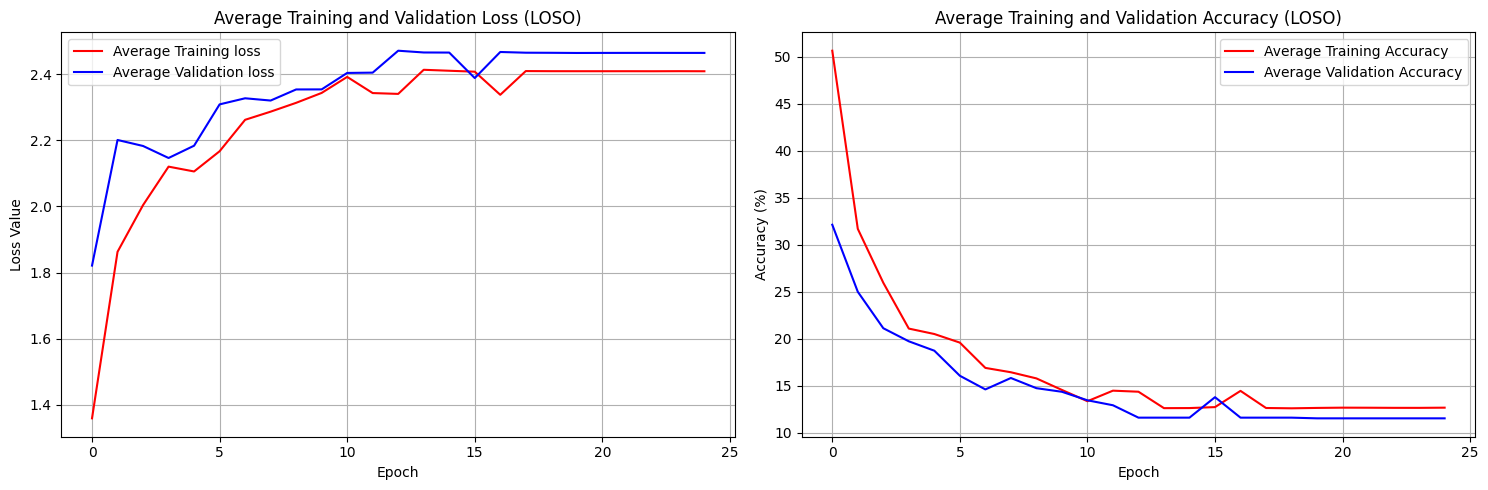

In [ ]:
# Aggregate and Visualize Final Results
max_len = max(len(l) for l in all_train_losses)
padded_train_losses = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_train_losses])
padded_val_losses = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_val_losses])
padded_train_accuracies = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_train_accuracies])
padded_val_accuracies = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_val_accuracies])

avg_train_loss = np.mean(padded_train_losses, axis=0)
avg_val_loss = np.mean(padded_val_losses, axis=0)
avg_train_acc = np.mean(padded_train_accuracies, axis=0)
avg_val_acc = np.mean(padded_val_accuracies, axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, 'r', label='Average Training loss')
plt.plot(avg_val_loss, 'b', label='Average Validation loss')
plt.title('Average Training and Validation Loss (LOSO)')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, 'r', label='Average Training Accuracy')
plt.plot(avg_val_acc, 'b', label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy (LOSO)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Final Classification Report (Aggregated LOSO) ---
                   precision    recall  f1-score   support

            lying     0.4689    0.9597    0.6300      2433
          sitting     0.5673    0.1668    0.2578      2374
         standing     0.3559    0.0753    0.1243      2378
          walking     0.2308    0.8099    0.3592      2882
          running     0.7727    0.0540    0.1009      1889
          cycling     0.3824    0.1547    0.2203      2385
   Nordic walking     0.2312    0.2492    0.2399      2636
 ascending stairs     0.3040    0.2164    0.2528      1451
descending stairs     0.1720    0.0212    0.0377      1274
  vacuum cleaning     0.5344    0.2261    0.3177      2269
          ironing     0.6189    0.6365    0.6275      3125
     rope jumping     0.4113    0.1708    0.2413       855

         accuracy                         0.3607     25951
        macro avg     0.4208    0.3117    0.2841     25951
     weighted avg     0.4292    0.3607    0.3132     25951

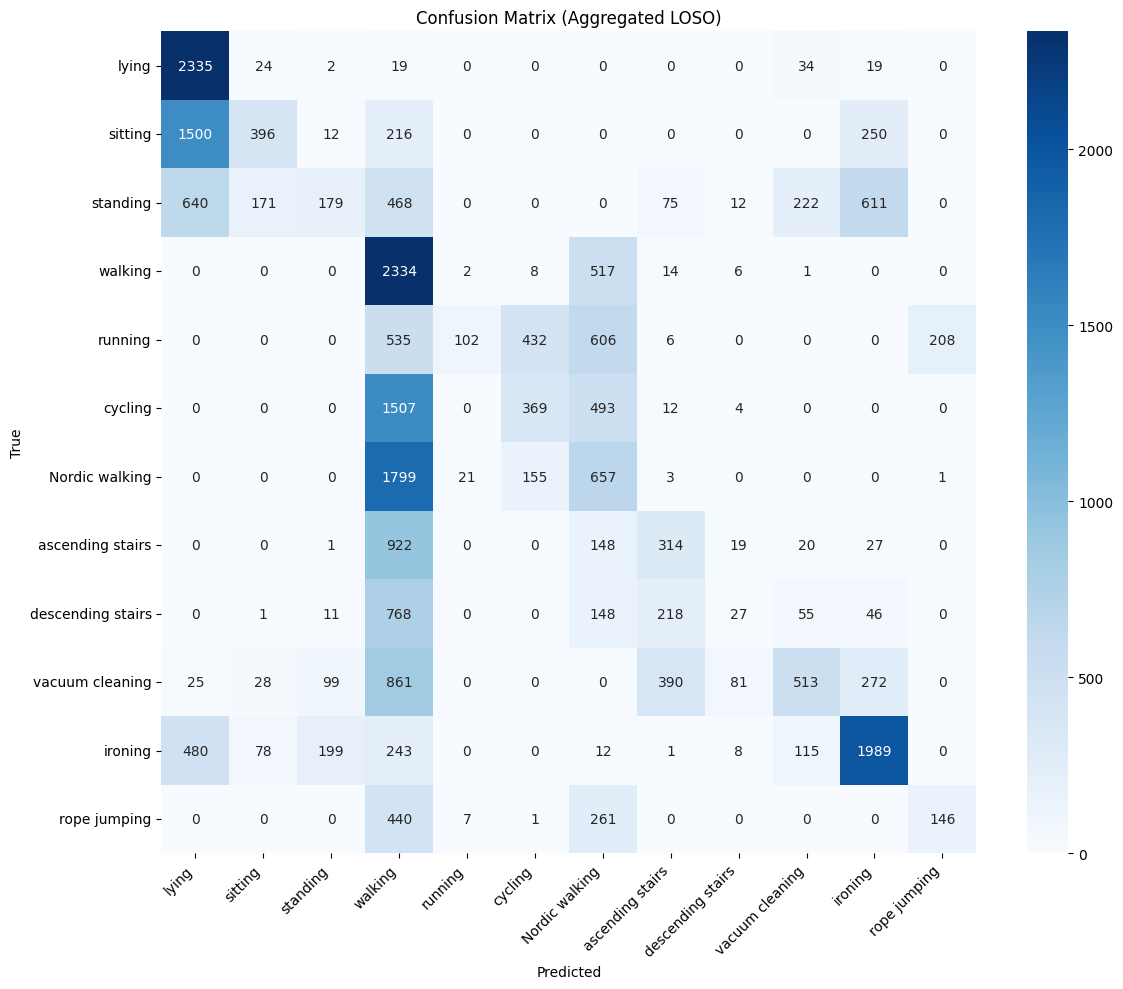

In [ ]:
# Final Classification Report and Confusion Matrix
print("\n--- Final Classification Report (Aggregated LOSO) ---")
LABELS = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling',
          'Nordic walking', 'ascending stairs', 'descending stairs',
          'vacuum cleaning', 'ironing', 'rope jumping']
target_names = [LABELS[i] for i in np.unique(all_labels)]
print(classification_report(all_labels, all_preds, digits=4, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated LOSO)')
plt.gca().set_xticklabels(target_names, rotation=45, ha='right')
plt.gca().set_yticklabels(target_names, rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# T-SNE Visualization
# 모든 테스트 데이터와 라벨을 합침
X_test_aggregated = np.concatenate(all_X_test, axis=0)
y_test_aggregated = np.array(all_labels)

# t-SNE는 계산량이 많으므로 일부 샘플만 사용
np.random.seed(42)
num_samples = 5000
if len(X_test_aggregated) > num_samples:
    indices = np.random.choice(len(X_test_aggregated), num_samples, replace=False)
    X_tsne = X_test_aggregated[indices]
    y_tsne = y_test_aggregated[indices]
else:
    X_tsne = X_test_aggregated
    y_tsne = y_test_aggregated

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 7.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 4.366546
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.018280
[t-SNE] KL divergence after 300 iterations: 1.980624


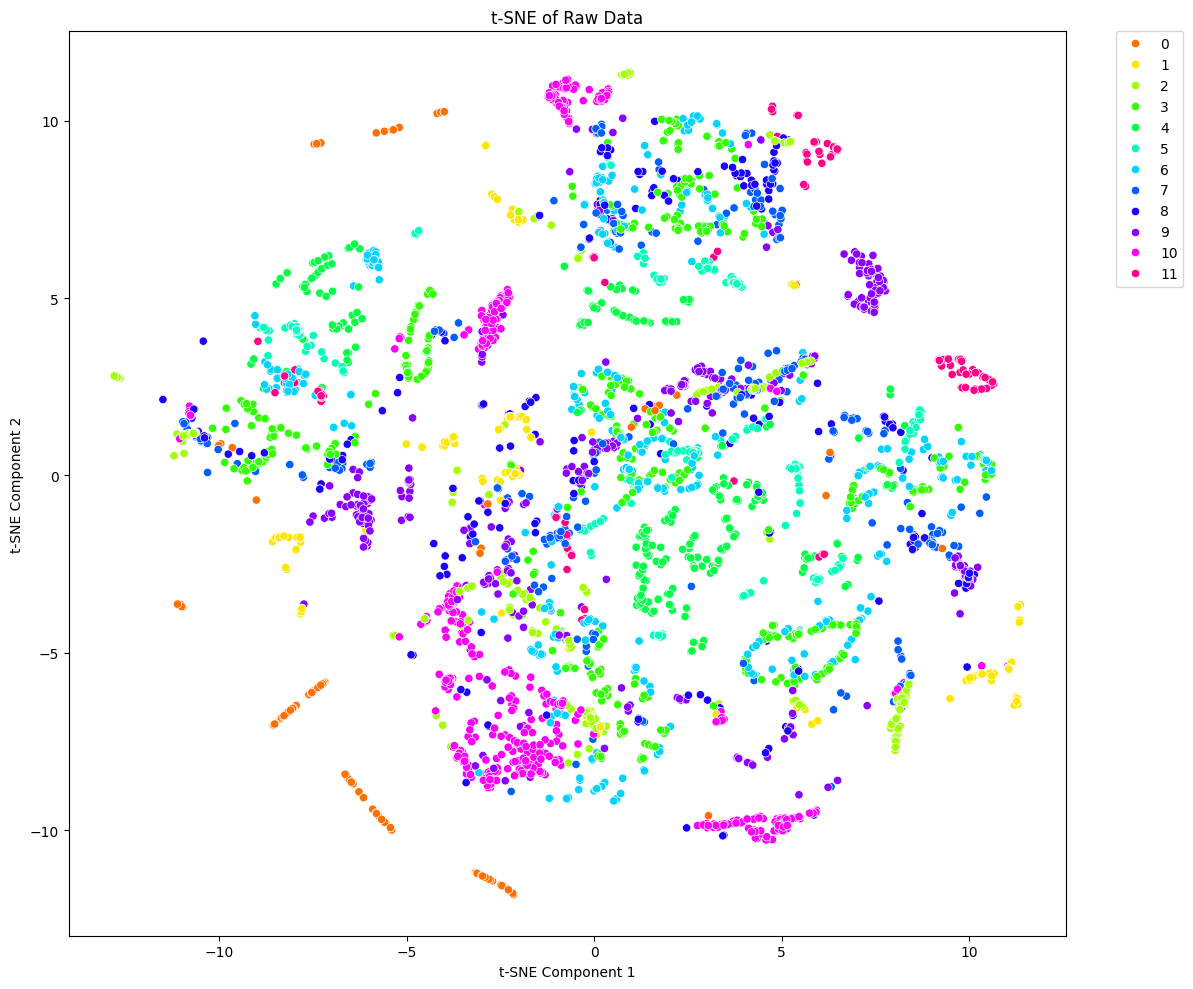

In [ ]:
# 1. 모델 적용 전 (원시 데이터) t-SNE
X_tsne_flat = X_tsne.reshape(X_tsne.shape[0], -1)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne_flat)

tsne_raw = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300).fit_transform(X_tsne_scaled)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=tsne_raw[:, 0], y=tsne_raw[:, 1], hue=y_tsne, palette=sns.color_palette("hsv", len(LABELS)), legend='full')
plt.title('t-SNE of Raw Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.816s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.882015
[t-SNE] KL divergence after 300 iterations: 1.426104


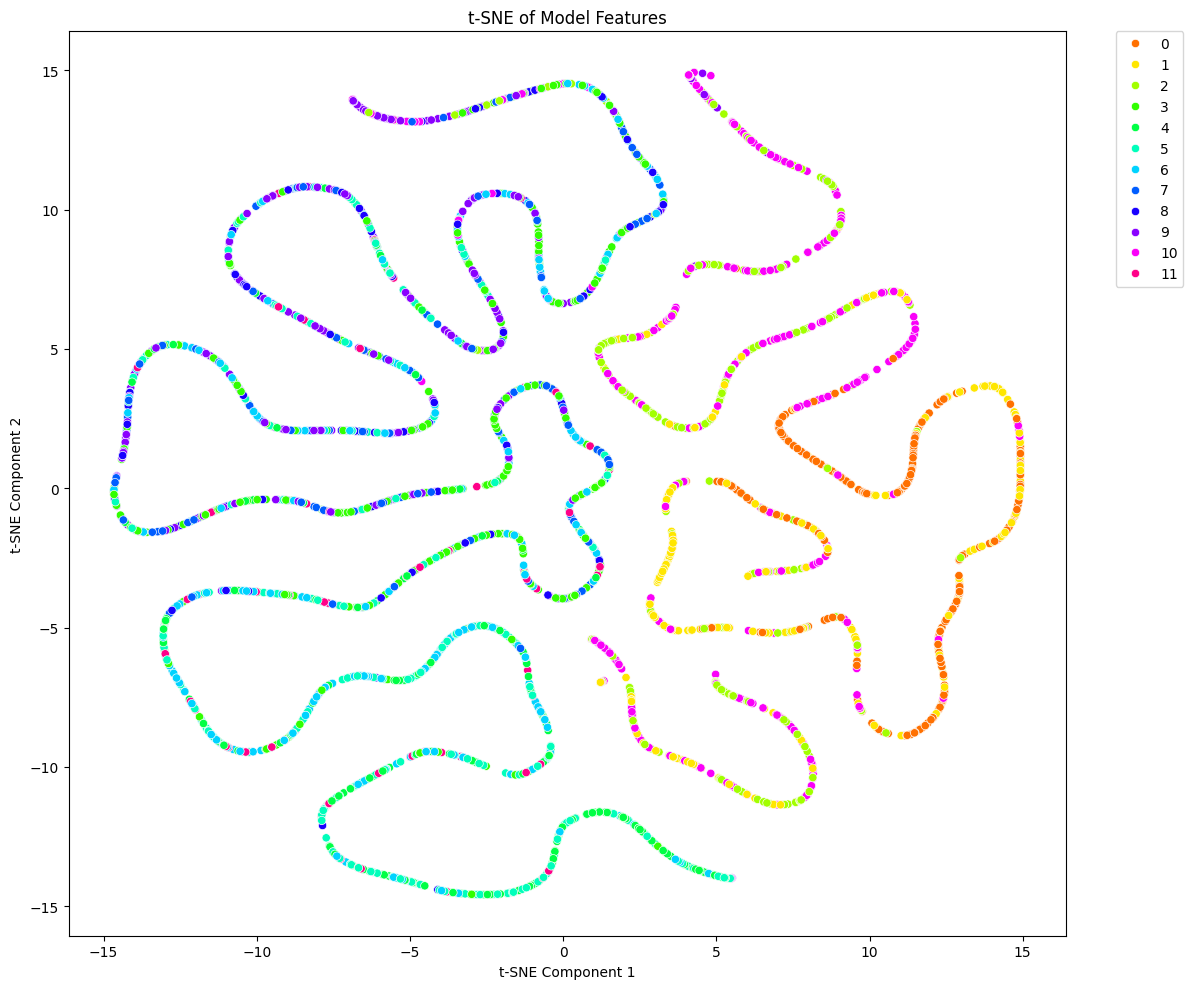

In [ ]:
# 2. 모델 적용 후 (특징) t-SNE
model.eval()
with torch.no_grad():
    test_data_tensor = torch.FloatTensor(X_tsne).to(device)
    test_data_tensor = test_data_tensor.permute(0, 2, 1)
    features = model.get_features(test_data_tensor).cpu().numpy()

tsne_features = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300).fit_transform(features)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=y_tsne, palette=sns.color_palette("hsv", len(LABELS)), legend='full')
plt.title('t-SNE of Model Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()